# Housing Rental & Venues in Gainesville, FL
## Description & Discussion of the Background
Gainesville is a Metropolitan Statistical Area (MSA) and is the largest city in North Central Florida. This city is the county seat and the largest city in Alachua County, Florida. In 2019 the US Census Bureau estimated Gainesville’s population at 133,997, a 7.6% increase compared to 2010, and the MSA population at 288,212.

Gainesville is the home to the University of Florida (UF). The University of Florida is the largest Florida university by student population, and is the fifth largest single-campus university in the United States with 56,567 students enrolled for the fall 2019 semester. Out of all 56,567 students, 3797 were enrolled through UF online. That means 52,770 students were going to the university in person, making 39.38% of the Gainesville population. 

This project will be focused on helping students who are looking to rent an off-campus apartment, but this could help anyone who is looking to rent an apartment in Gainesville. With this, students could find affordable apartments to live near or far from the university. They could also find the most popular venues around their house or university.The students who live with their parents could use this to find the most popular places or if they make a decision to find an apartment to live by themselves, this could facilitate the process. 

## Data Description 
For this project I will be using data from:
* To find apartments for rent in Gainesville I used the [Realtor API](https://rapidapi.com/apidojo/api/realtor). For the apartment data, I only used the address, zip code, latitude, longitude, price minimum, and price maximum. I added the average price for each apartment using the min price and the max price, and for the distance between an apartment and the University of Florida, I used the latitude and longitude from one point to the other one using [Geopy](https://geopy.readthedocs.io/en/stable/). Here is my [(dataset)](/Data/apt_for_rent_in_gainesville.csv)
* I used the [Foursquare API](https://developer.foursquare.com) to get the most common venues in a 0.5 miles radius around each apartment given address, latitudes, longitudes, avg prices. Here is my [(dataset)](/Data/apt_and_venues_in_gainesville.csv)
* For Gainesville geo boundaries I used the [UA Census Zip Code Tabulation Areas, 2000 - Florida](https://geo.nyu.edu/catalog/harvard-tg00flzcta). The JSON file had geo-coordinates of all the cities in Florida. To use this file I had to clean the data and reduced it to the city of Gainesville, FL because the file was big and it had data that I didn't need. I used this data to create the choropleth map of the Housing Rental Price Index of Gainesville, FL. Here is my [(dataset)](/GeoJSON/gainesville_geo.json).

### Import libraries

In [151]:
# Import libraries
import pandas as pd
from geopy.distance import geodesic
import requests
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import folium
import geopandas
import seaborn as sns
import numpy as np
from matplotlib.pylab import plt
import matplotlib.cm as cm
import matplotlib.colors as colors


# Pandas output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

### Create a function to get apartments for rent in Gainesville

In [143]:
# Get apartment for rent in Gainesville
def get_apartment_for_rent(limit=100):

    # Apartments list
    apartments_list = []

    # API request URL
    url = "https://realtor.p.rapidapi.com/properties/v2/list-for-rent"

    querystring = {"city": "Gainesville",
                   "state_code": "FL",
                   "limit": limit,
                   "offset": "0",
                   "sort": "relevance"}

    headers = {
        'x-rapidapi-key': " ",
        'x-rapidapi-host': "realtor.p.rapidapi.com"
    }

    # Make the GET request
    response = requests.request("GET", url, headers=headers, params=querystring).json()['properties']

    # Return only relevant information for each nearby apartment
    apartments_list.append([(
        apt['address']['line'],
        apt['address']['postal_code'],
        apt['address']['lat'],
        apt['address']['lon'],
        apt['community']['price_min'],
        apt['community']['price_max'],
        apt['community']['sqft_min'],
        apt['community']['sqft_max']) for apt in response])

    # Apartment dataframe
    apartments_for_rent = pd.DataFrame([item for apartments_list in apartments_list for item in apartments_list])

    # Apartment columns
    apartments_for_rent.columns = ['Address', 'ZipCode', 'Latitude', 'Longitude', 'Min Price', 'Max Price', 'Min Sqft', 'Max Sqft']

    # Return apartment dataframe
    return apartments_for_rent

### Create a function to get the venues for every apartment in Gainesville

In [3]:
# Get the venues for every apartment in Gainesville
def get_nearby_venues(address, zipcodes, latitudes, longitudes, avg_prices, radius=804.672):

    # Define Foursquare Credentials and Version
    CLIENT_ID = ' '  # your Foursquare ID
    CLIENT_SECRET = ' '  # your Foursquare Secret
    VERSION = '20180605'  # Foursquare API version
    LIMIT = 100  # A default Foursquare API limit value

    # Venues list
    venues_list = []

    # Get the venues nearby for each apartment
    for addrss, zipcode, lat, lng, avg_price in zip(address, zipcodes, latitudes, longitudes, avg_prices):

        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # Return only relevant information for each nearby venue
        venues_list.append([(
            addrss,
            zipcode,
            lat,
            lng,
            avg_price,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    # Venues dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    # Venues columns
    nearby_venues.columns = ['Address',
                             'ZipCode',
                             'Latitude',
                             'Longitude',
                             'Avg Price',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    # Return venues
    return nearby_venues

### Create a function to get the distance between point A to point B

In [4]:
# Get distance between two points in miles
def get_distance_between_two_points(point_A, point_two_lat_lng, df):
    # Distance list
    distance_ = []

    # Get the distance for every point B in the dataframe
    for i in range(df.count()):
        # Point B (This is all the point that you want to measure from df)
        point_B = (point_two_lat_lng[0][i], point_two_lat_lng[1][i])

        # Distance in miles from one point to the other one
        distance_.append(geodesic(point_A, point_B).miles) # Add every distance to a list

    # Return distance
    return distance_

### Create a function to to sort the venues in descending order

In [5]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venue):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    # Return values
    return row_categories_sorted.index.values[0:num_top_venue]

### Define the geopoints for the University of Florida

In [6]:
# University of Florida geopoints
uf_lat_lng = (29.6436, -82.3549)

uf_lat_lng

(29.6436, -82.3549)

### Apartments for rent in Gainesville
* Call the function to get the apartments
* Find the average price for each apartment by (adding avg min & avg max and then dividing the result by two) and then add the result to the apt dataframe 
* Define the Address, Latitude, Avg Price, and Apt latitude and longitude variable
* Get the distance between each apartment to the University (UF) and add it to the dataframe
* Print the apartments for rent

In [320]:
# Apartments for rent in Gainesville (Dataframe
apt_for_rent_df = get_apartment_for_rent()


# Calculation
apt_for_rent_df['Avg Price'] = (apt_for_rent_df['Min Price'] + apt_for_rent_df['Max Price']) / 2 # Find average rent price
apt_for_rent_df['Avg Sqft'] = (apt_for_rent_df['Min Sqft'] + apt_for_rent_df['Max Sqft']) / 2 # Find average rent sqft
apt_for_rent_df['Avg Price/Sqft'] = (apt_for_rent_df['Avg Price'] / apt_for_rent_df['Avg Sqft']).round(2) # Find the avg price per Sqft


# Drop columns that we are not going to use
apt_for_rent_df.drop(columns={'Min Price', 'Max Price', 'Min Sqft', 'Max Sqft'}, inplace=True)


# Get the distance between the apartment and the University of Florida
#apt_for_rent_df['UF-Apt Distance'] = get_distance_between_two_points(uf_lat_lng, apartments_lat_lng, apt_address)
#apt_distance = apt_for_rent_df['UF-Apt Distance']

# Print result
apt_for_rent_df.head(10)

Address ZipCode   Latitude  Longitude  Avg Price  Avg Sqft  \
0     311 SW 13th St   32601  29.649057 -82.338943      854.0     935.5   
1   6001 SW 75th Ter   32608  29.599560 -82.422520     1513.5    1119.5   
2   3980 SW 24th Ave   32607  29.630842 -82.383229     1812.0    1056.5   
3    3000 SW 35th Pl   32608  29.623600 -82.367160      709.0    1356.5   
4   1101 NW 39th Ave   32609  29.688300 -82.336860     1085.0     922.5   
5  4000 SW 37th Blvd   32608  29.616148 -82.378658      479.0     375.0   
6  3415 SW 39th Blvd   32608  29.616714 -82.373300      509.0     900.5   
7     205 SW 75th St   32607  29.650135 -82.420359      914.0    1056.0   
8    3700 SW 27th St   32608  29.616662 -82.363765      634.0    1170.0   
9   316 SW 62nd Blvd   32607  29.650060 -82.409010     1088.5     831.5   

   Avg Price/Sqft  
0            0.91  
1            1.35  
2            1.72  
3            0.52  
4            1.18  
5            1.28  
6            0.57  
7            0.87  
8            0.54  
9            1.31

### Apt for rent shape
* In the dataframe are 100 apartments and 7 column with differents points

In [321]:
apt_for_rent_df.shape

(100, 7)

#### For this project I only used the apartements that cost less than $900 a month

In [350]:
# Find all the apartment that avg price is less than $900
cheap_apt_for_rent_df = apt_for_rent_df[apt_for_rent_df['Avg Price'] <= 900]

# Reset index
cheap_apt_for_rent_df.reset_index(inplace=True, drop=True)

# Variables
apt_address = cheap_apt_for_rent_df['Address']
apt_zipcode = cheap_apt_for_rent_df['ZipCode']
apt_lat = cheap_apt_for_rent_df['Latitude']
apt_lng = cheap_apt_for_rent_df['Longitude']
apt_avg_price = cheap_apt_for_rent_df['Avg Price']


# Apartments latitude and longitude
apartments_lat_lng = (apt_lat, apt_lng)


# Print result
cheap_apt_for_rent_df.head()

Address ZipCode   Latitude  Longitude  Avg Price  Avg Sqft  \
0     311 SW 13th St   32601  29.649057 -82.338943      854.0     935.5   
1    3000 SW 35th Pl   32608  29.623600 -82.367160      709.0    1356.5   
2  4000 SW 37th Blvd   32608  29.616148 -82.378658      479.0     375.0   
3  3415 SW 39th Blvd   32608  29.616714 -82.373300      509.0     900.5   
4    3700 SW 27th St   32608  29.616662 -82.363765      634.0    1170.0   

   Avg Price/Sqft  
0            0.91  
1            0.52  
2            1.28  
3            0.57  
4            0.54

#### Now we can see that there are only 33 apartments that cost less than $900 a month

In [351]:
cheap_apt_df.shape

(33, 9)

### Create a map of the apartments for rent in Gainesville using latitude and longitude values

In [352]:
# Map of apartments for rent in Gainesville using latitude and longitude values
def create_apt_for_rent_map(lat_df, lng_df):
    # Create map of Toronto, Ontario using latitude and longitude values
    apt_for_rent_map = folium.Map(location=[lat_df, lng_df], zoom_start=12)
    
    # Add all the venues into a cluster
    #marker_cluster = MarkerCluster().add_to(apt_for_rent_map)
    
    # Add a market for the University of Florida location
    folium.Marker(location=[29.6436, -82.3549], 
                  popup=(folium.Popup('University of Florida')),
                  icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(apt_for_rent_map)



    # Add markers to map
    for lat, lng, address, avg_prices in zip(cheap_apt_for_rent_df['Latitude'], cheap_apt_for_rent_df['Longitude'], 
                                cheap_apt_for_rent_df['Address'], cheap_apt_for_rent_df['Avg Price']):
        
        # Label the map
        label = '{}, ${}'.format(address, avg_prices)
        label = folium.Popup(label, parse_html=True)
        
        # Make circle in the map for each neighborhood
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(apt_for_rent_map)
    
    # Return map
    return apt_for_rent_map


### Apartments for rent in Gainesville Map
* Create the apartments for rent in Gainesville map
* Show the map

In [353]:
# Map
apt_for_rent_map = create_apt_for_rent_map(29.6436, -82.3549)

# Display Map
apt_for_rent_map

### Apartments for rent and venues in Gainesville
* Call the function to get the venues with the apartments for rent
* Define the Venue, Venue Latitude, Venue Longitude, and Venue Category variables
* Print the venues with the apartments for rent 

In [354]:
# Gainesville dataframe with venues and apartments for rent
apt_and_venues_nearby_df = get_nearby_venues(apt_address, apt_zipcode, apt_lat, apt_lng, apt_avg_price)


# Variables
v_name = apt_and_venues_nearby_df['Venue']
v_category = apt_and_venues_nearby_df['Venue Category']

# Print result
apt_and_venues_nearby_df.head()

Address ZipCode   Latitude  Longitude  Avg Price  \
0  311 SW 13th St   32601  29.649057 -82.338943      854.0   
1  311 SW 13th St   32601  29.649057 -82.338943      854.0   
2  311 SW 13th St   32601  29.649057 -82.338943      854.0   
3  311 SW 13th St   32601  29.649057 -82.338943      854.0   
4  311 SW 13th St   32601  29.649057 -82.338943      854.0   

                 Venue  Venue Latitude  Venue Longitude        Venue Category  
0     Leonardo's Pizza       29.651971       -82.338585           Pizza Place  
1          Karma Cream       29.651906       -82.335961        Ice Cream Shop  
2  Chick-fil-A Express       29.647178       -82.341564  Fast Food Restaurant  
3               Publix       29.653261       -82.338995         Grocery Store  
4          Chick-fil-A       29.652259       -82.339679          Food Service

### Venues with apartments shape

* In the dataframe are 854 venues and 9 column with differents points

In [356]:
apt_and_venues_nearby_df.shape

(854, 9)

### Create a map of the venues with apartments for rent in Gainesville using latitude and longitude values

In [357]:
# Map of Toronto, Ontario using latitude and longitude values
def create_venues_nearby_map(lat_df, lng_df):
    # Create map of Toronto, Ontario using latitude and longitude values
    venues_nearby_map = folium.Map(location=[lat_df, lng_df], zoom_start=12)
    
    # Add all the venues into a cluster
    marker_cluster = MarkerCluster().add_to(venues_nearby_map)
    
    # Add a market for the University of Florida location
    folium.Marker(location=[29.6436, -82.3549], 
                  popup=(folium.Popup('University of Florida')),
                  icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(venues_nearby_map)

    # Add markers to map
    for lat, lng, venues, venues_category in zip(apt_and_venues_nearby_df['Venue Latitude'], apt_and_venues_nearby_df['Venue Longitude'], 
                                apt_and_venues_nearby_df['Venue'], apt_and_venues_nearby_df['Venue Category']):
        
        # Label the map
        label = '{}, {}'.format(venues, venues_category)
        label = folium.Popup(label, parse_html=True)
        
        # Make circle in the map for each neighborhood
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster)
    
    # Return map
    return venues_nearby_map


### Venues with apartments for rent in Gainesville Map

* Create the venues with apartments for rent in Gainesville map
* Show the map

In [358]:
# Map
venues_nearby_map = create_venues_nearby_map(29.6436, -82.3549)

# Display Map
venues_nearby_map

### Plot the number of apartments that are in the same zipcode

<AxesSubplot:xlabel='ZipCode', ylabel='count'>

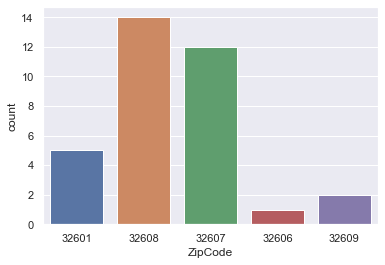

In [361]:
# Plot the number of apartments that are in the same zipcode
sns.set_theme(style="darkgrid")
sns.countplot(x="ZipCode", data=cheap_apt_for_rent_df)

### Plot UF-Apt Distance vs Avg Price

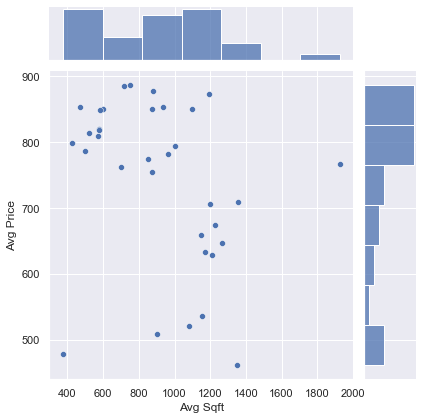

In [362]:
# Plot UF-Apt Distance vs Avg Price
sns.jointplot(x='Avg Sqft', y='Avg Price', data=cheap_apt_for_rent_df[['Avg Sqft', 'Avg Price']])

### Plot Avg Price/Sqft vs Avg Price

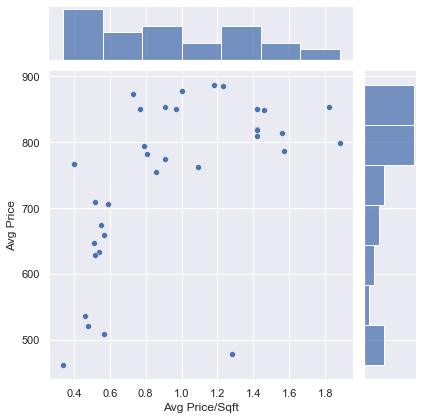

In [404]:
# Plot Avg Price/Sqft vs Avg Price
sns.jointplot(x='Avg Price/Sqft', y='Avg Price', data=cheap_apt_for_rent_df[['Avg Price/Sqft', 'Avg Price']])

### Convert the Dataframe into 0 and 1

In [364]:
gainesville_df = apt_and_venues_nearby_df

# One hot encoding
gainesville_onehot = pd.get_dummies(gainesville_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
gainesville_onehot.insert(loc=0, column='Address', value=gainesville_df['Address'])

# Print result
gainesville_onehot.head(10)

Address  American Restaurant  Arepa Restaurant  Art Gallery  \
0  311 SW 13th St                    0                 0            0   
1  311 SW 13th St                    0                 0            0   
2  311 SW 13th St                    0                 0            0   
3  311 SW 13th St                    0                 0            0   
4  311 SW 13th St                    0                 0            0   
5  311 SW 13th St                    0                 0            0   
6  311 SW 13th St                    0                 0            0   
7  311 SW 13th St                    0                 0            0   
8  311 SW 13th St                    0                 0            0   
9  311 SW 13th St                    0                 0            0   

   Arts & Crafts Store  Asian Restaurant  Assisted Living  Auto Workshop  \
0                    0                 0                0              0   
1                    0                 0                0              0   
2                    0                 0                0              0   
3                    0                 0                0              0   
4                    0                 0                0              0   
5                    0                 0                0              0   
6                    0                 0                0              0   
7                    0                 0                0              0   
8                    0                 0                0              0   
9                    0                 0                0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   
5                0          0           0           0       0     0    0   
6                0          0           0           0       0     0    0   
7                0          0           0           0       0     0    0   
8                0          0           0           0       0     0    0   
9                0          0           0           0       0     0    0   

   Baseball Field  Beer Bar  Big Box Store  Bookstore  Boutique  \
0               0         0              0          0         0   
1               0         0              0          0         0   
2               0         0              0          0         0   
3               0         0              0          0         0   
4               0         0              0          0         0   
5               0         0              0          0         0   
6               0         0              0          0         0   
7               0         0              0          0         0   
8               0         0              0          0         0   
9               0         0              0          0         0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  \
0               0        0            0                0       0   
1               0        0            0                0       0   
2               0        0            0                0       0   
3               0        0            0                0       0   
4               0        0            0                0       0   
5               0        0            0                0       0   
6               0        0            0                0       0   
7               0        0            0                0       0   
8               0        0            0                0       0   
9               0        0            0                0       0   

   Burger Joint  Burrito Place  Bus Station  

### Group the result by the Address and Find the Mean

In [365]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
gainesville_grouped = gainesville_onehot.groupby('Address').mean().reset_index()

# Print result
gainesville_grouped.head(10)


Address  American Restaurant  Arepa Restaurant  Art Gallery  \
0  1000 SW 62nd Blvd             0.000000          0.000000     0.000000   
1   1015 NW 21st Ave             0.000000          0.000000     0.019231   
2    117 SE 16th Ave             0.000000          0.000000     0.000000   
3    1231 SW 3rd Ave             0.046875          0.015625     0.000000   
4    1303 SW 13th St             0.031250          0.000000     0.000000   
5   1405 SW 10th Ter             0.043478          0.000000     0.000000   
6   1601 SW 51st Ter             0.000000          0.000000     0.000000   
7   1901 SW 40th Ter             0.000000          0.000000     0.000000   
8   1902 SW 42nd Way             0.000000          0.000000     0.000000   
9  2777 SW Archer Rd             0.047619          0.000000     0.000000   

   Arts & Crafts Store  Asian Restaurant  Assisted Living  Auto Workshop  \
0                  0.0           0.00000         0.111111       0.000000   
1                  0.0           0.00000         0.000000       0.019231   
2                  0.0           0.00000         0.000000       0.000000   
3                  0.0           0.00000         0.000000       0.000000   
4                  0.0           0.03125         0.000000       0.000000   
5                  0.0           0.00000         0.000000       0.000000   
6                  0.0           0.00000         0.111111       0.000000   
7                  0.0           0.00000         0.000000       0.000000   
8                  0.0           0.00000         0.000000       0.000000   
9                  0.0           0.00000         0.000000       0.000000   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  \
0         0.000000   0.000000    0.000000     0.00000     0.0  0.000000   
1         0.000000   0.019231    0.019231     0.00000     0.0  0.038462   
2         0.000000   0.142857    0.000000     0.00000     0.0  0.000000   
3         0.000000   0.015625    0.000000     0.00000     0.0  0.015625   
4         0.000000   0.031250    0.000000     0.03125     0.0  0.000000   
5         0.000000   0.043478    0.000000     0.00000     0.0  0.000000   
6         0.000000   0.000000    0.000000     0.00000     0.0  0.000000   
7         0.000000   0.000000    0.000000     0.00000     0.0  0.000000   
8         0.000000   0.000000    0.000000     0.00000     0.0  0.000000   
9         0.047619   0.000000    0.000000     0.00000     0.0  0.000000   

        Bar  Baseball Field  Beer Bar  Big Box Store  Bookstore  Boutique  \
0  0.000000             0.0  0.000000       0.000000   0.000000       0.0   
1  0.000000             0.0  0.000000       0.000000   0.019231       0.0   
2  0.000000             0.0  0.000000       0.000000   0.000000       0.0   
3  0.046875             0.0  0.000000       0.015625   0.000000       0.0   
4  0.000000             0.0  0.031250       0.000000   0.000000       0.0   
5  0.000000             0.0  0.043478       0.000000   0.000000       0.0   
6  0.000000             0.0  0.000000       0.000000   0.000000       0.0   
7  0.000000             0.0  0.000000       0.000000   0.000000       0.0   
8  0.000000             0.0  0.000000       0.000000   0.000000       0.0   
9  0.000000             0.0  0.000000       0.000000   0.000000       0.0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop    Buffet  \
0        0.000000      0.0          0.0              0.0  0.000000   
1        0.019231      0.0          0.0              0.0  0.000000   
2        0.000000      0.0          0.0              0.0  0.000000   
3        0.015625      0.0          0.0              0.0  0.015625   
4        0.000000      0.0          0.0              0.0  0.000000   
5        0.000000      0.0          0.0              0.0  0.000000   
6        0.000000      0.0          0.0              0.0  0.000000   
7        0.000000      0.0          0.0              0.0  0.000000   
8        0.000000      0.0         

### Create Columns According to Number of Top Venues

In [366]:
# Variables
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        

### Create New Dataframe with Most Common Venues Sorted

In [407]:
# Create a new dataframe
apt_and_venues_sorted_df = pd.DataFrame(columns=columns)
apt_and_venues_sorted_df['Address'] = gainesville_grouped['Address']

# Get every venue sorted for each apartment
for ind in np.arange(gainesville_grouped.shape[0]):
    apt_and_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(gainesville_grouped.iloc[ind, :], num_top_venues)

# Print dataframe
apt_and_venues_sorted_df.head(10)


Address 1st Most Common Venue 2nd Most Common Venue  \
0  1000 SW 62nd Blvd                   Gym               Dog Run   
1   1015 NW 21st Ave      Department Store           Coffee Shop   
2    117 SE 16th Ave            Food Truck          Liquor Store   
3    1231 SW 3rd Ave        Sandwich Place  Fast Food Restaurant   
4    1303 SW 13th St          Liquor Store  Fast Food Restaurant   
5   1405 SW 10th Ter          Liquor Store                 Hotel   
6   1601 SW 51st Ter                   Gym                  Park   
7   1901 SW 40th Ter           Wings Joint                 Hotel   
8   1902 SW 42nd Way                  Park           Wings Joint   
9  2777 SW Archer Rd                   Gym    Italian Restaurant   

  3rd Most Common Venue   4th Most Common Venue   5th Most Common Venue  \
0            Hotel Pool  Furniture / Home Store                    Pool   
1        Discount Store                    Bank  Furniture / Home Store   
2             Rock Club          Discount Store        Business Service   
3           Coffee Shop     American Restaurant                     Bar   
4                 Hotel          Sandwich Place                    Pool   
5   American Restaurant                    Lake          Discount Store   
6           Wings Joint              Hotel Pool             Video Store   
7    Italian Restaurant     Sporting Goods Shop             Video Store   
8            Hotel Pool             Video Store       Convenience Store   
9           Bus Station     American Restaurant          Breakfast Spot   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0       Assisted Living           Gas Station     Electronics Store   
1             Pet Store              Pharmacy         Grocery Store   
2             BBQ Joint         Grocery Store          Food Service   
3    Mexican Restaurant           Pizza Place      Sushi Restaurant   
4      Business Service                  Café    Chinese Restaurant   
5             Rock Club    Salon / Barbershop        Sandwich Place   
6     Convenience Store       Assisted Living           Bus Station   
7     Convenience Store           Bus Station                  Park   
8           Bus Station           Yoga Studio     Food & Drink Shop   
9      Insurance Office     Health Food Store           Gas Station   

  9th Most Common Venue  10th Most Common Venue  
0     Food & Drink Shop    Fast Food Restaurant  
1           Supermarket  Thrift / Vintage Store  
2            Food Court       Food & Drink Shop  
3      Sculpture Garden              Donut Shop  
4    Salon / Barbershop             Coffee Shop  
5      Business Service    Fast Food Restaurant  
6           Yoga Studio       Food & Drink Shop  
7           Yoga Studio       Electronics Store  
8  Fast Food Restaurant                    Farm  
9     Mobile Phone Shop    Fast Food Restaurant

### The Elbow Method to Find the Optimal K

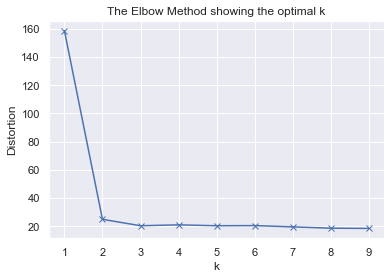

In [408]:
gainesville_grouped_clustering = gainesville_grouped.drop('Address', 1)

distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(gainesville_grouped_clustering)
    kmeanModel.fit(gainesville_grouped_clustering)
    distortions.append(sum(np.min(cdist(gainesville_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / gainesville_grouped_clustering.shape[0])

# There are different metric distance function for spatial distance.
# I choose correlation instead of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### Run K-Means Clustering

In [409]:

# Set number of clusters
kclusters = 3

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gainesville_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

[0 0 0 0 0 0 2 2 2 0]


### Add Clustering Labels to Dataframe

In [410]:
# Add clustering labels
apt_and_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

gainesville_merged = gainesville_df

# Merge gainesville_grouped with gainesville_data to add latitude/longitude for each neighborhood
gainesville_merged = gainesville_merged.join(apt_and_venues_sorted_df.set_index('Address'), on='Address')

# Print result
gainesville_merged.head(10)

Address ZipCode   Latitude  Longitude  Avg Price  \
0  311 SW 13th St   32601  29.649057 -82.338943      854.0   
1  311 SW 13th St   32601  29.649057 -82.338943      854.0   
2  311 SW 13th St   32601  29.649057 -82.338943      854.0   
3  311 SW 13th St   32601  29.649057 -82.338943      854.0   
4  311 SW 13th St   32601  29.649057 -82.338943      854.0   
5  311 SW 13th St   32601  29.649057 -82.338943      854.0   
6  311 SW 13th St   32601  29.649057 -82.338943      854.0   
7  311 SW 13th St   32601  29.649057 -82.338943      854.0   
8  311 SW 13th St   32601  29.649057 -82.338943      854.0   
9  311 SW 13th St   32601  29.649057 -82.338943      854.0   

                                             Venue  Venue Latitude  \
0                                 Leonardo's Pizza       29.651971   
1                                      Karma Cream       29.651906   
2                              Chick-fil-A Express       29.647178   
3                                           Publix       29.653261   
4                                      Chick-fil-A       29.652259   
5                       Piesanos Stone Fired Pizza       29.652302   
6                            Plaza of the Americas       29.650275   
7                           Krispy Kreme Doughnuts       29.654209   
8  Pascal's Coffeehouse and Christian Study Center       29.653270   
9                                         El Indio       29.655098   

   Venue Longitude        Venue Category  Cluster Labels  \
0       -82.338585           Pizza Place               0   
1       -82.335961        Ice Cream Shop               0   
2       -82.341564  Fast Food Restaurant               0   
3       -82.338995         Grocery Store               0   
4       -82.339679          Food Service               0   
5       -82.339009           Pizza Place               0   
6       -82.342887                 Plaza               0   
7       -82.339603            Donut Shop               0   
8       -82.343226           Coffee Shop               0   
9       -82.339106    Mexican Restaurant               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
1        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
2        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
3        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
4        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
5        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
6        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
7        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
8        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   
9        Sandwich Place  Fast Food Restaurant    Mexican Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Pizza Place           Coffee Shop                   Bar   
1           Pizza Place           Coffee Shop                   Bar   
2           Pizza Place           Coffee Shop                   Bar   
3           Pizza Place           Coffee Shop                   Bar   
4           Pizza Place           Coffee Shop                   Bar   
5           Pizza Place           Coffee Shop                   Bar   
6           Pizza Place           Coffee Shop                   Bar   
7           Pizza Place           Coffee Shop                   Bar   
8           Pizza Place           Coffee Shop                   Bar   
9           Pizza Place           Coffee Shop                   Bar   

  7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0   American Restaurant            Donut Shop  Vietnamese Restaurant   
1   American Restaurant            Donut Shop  Vietnamese Restaurant   
2   American Restaurant            Donut Shop  Vietnamese Restaurant   
3   American Restaurant            Donut Sh

### Find the count for each cluster

In [412]:
# Find Label Names for Each Cluster
count_venue = gainesville_merged
count_venue = count_venue.drop(['Address','ZipCode', 'Latitude', 'Longitude', 'Avg Price'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue  American Restaurant  Clothing Store  Department Store  \
0                                      281              38                52   
1                                        0               0                 0   
2                                        0               0                 0   

1st Most Common Venue  Fast Food Restaurant  Food Truck  Garden  Gym  Hotel  \
0                                        56           7       3   30     87   
1                                         0           0       0    0      0   
2                                         0           0       0    9      0   

1st Most Common Venue  Liquor Store  Park  Pizza Place  Pool  Sandwich Place  \
0                                79    14           24     0             134   
1                                 0     0            0     4               0   
2                                 0    11            0     0               0   

1st Most Common Venue  Soccer Field  Spanish Restaurant  Wings Joint  
0                                 6                  11            0  
1                                 0                   0            0  
2                                 0                   0            8

### Plot the new data to visualize the result

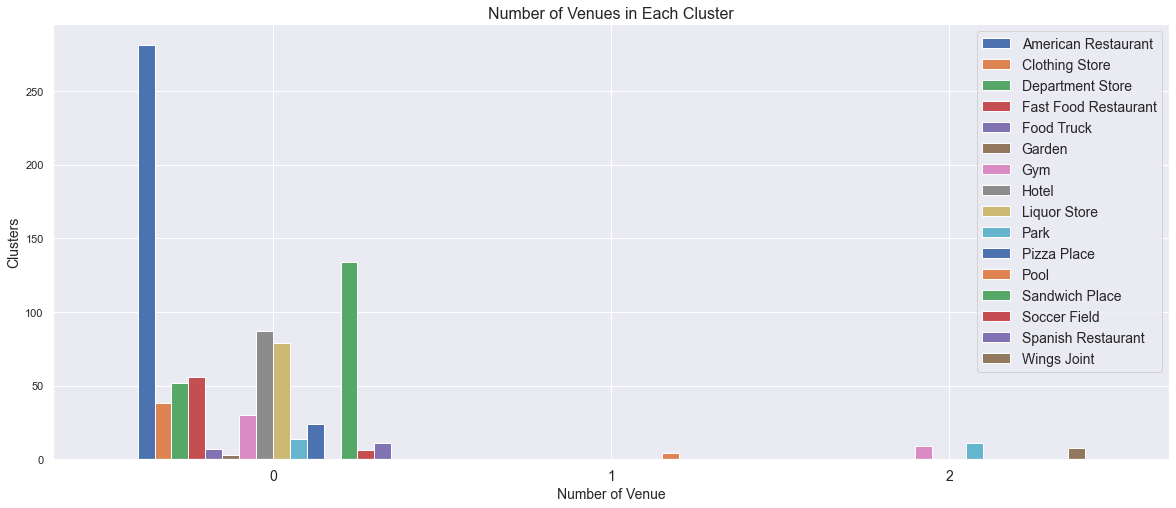

In [413]:
# Creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

# Creat thhe graph
plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.show()

### Grouped each address by the number of top 3 venues

In [420]:
# Grouped each address by the number of top 3 venues
top3_venues = apt_and_venues_nearby_df.groupby(['Address', 'Venue Category']).size().reset_index(name='Counts')
top3_venues = top3_venues.sort_values(['Address', 'Counts'],ascending=False).groupby('Address').head(3).reset_index(drop=True)

top3_venues['Top 3 Venues'] = top3_venues['Counts'].map(str) + " " + top3_venues['Venue Category']
top3_venues = top3_venues.groupby(['Address'])['Top 3 Venues'].apply(", ".join).reset_index()

top3_venues.head()

Address                                       Top 3 Venues
0  1000 SW 62nd Blvd                3 Gym, 1 Assisted Living, 1 Dog Run
1   1015 NW 21st Ave          3 Coffee Shop, 3 Department Store, 2 Bank
2    117 SE 16th Ave  1 BBQ Joint, 1 Business Service, 1 Discount Store
3    1231 SW 3rd Ave  8 Sandwich Place, 5 Fast Food Restaurant, 4 Co...
4    1303 SW 13th St    3 Fast Food Restaurant, 3 Liquor Store, 2 Hotel

### Merge the new data with related cluster information

In [423]:
# Merge the new data with related cluster information
result_df = pd.merge(gainesville_merged, top3_venues[['Address', 'Top 3 Venues']], left_on='Address', right_on='Address', how='left')

# Print result
result_df.head()

Address ZipCode   Latitude  Longitude  Avg Price  \
0  311 SW 13th St   32601  29.649057 -82.338943      854.0   
1  311 SW 13th St   32601  29.649057 -82.338943      854.0   
2  311 SW 13th St   32601  29.649057 -82.338943      854.0   
3  311 SW 13th St   32601  29.649057 -82.338943      854.0   
4  311 SW 13th St   32601  29.649057 -82.338943      854.0   

                 Venue  Venue Latitude  Venue Longitude        Venue Category  \
0     Leonardo's Pizza       29.651971       -82.338585           Pizza Place   
1          Karma Cream       29.651906       -82.335961        Ice Cream Shop   
2  Chick-fil-A Express       29.647178       -82.341564  Fast Food Restaurant   
3               Publix       29.653261       -82.338995         Grocery Store   
4          Chick-fil-A       29.652259       -82.339679          Food Service   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0        Sandwich Place  Fast Food Restaurant   
1               0        Sandwich Place  Fast Food Restaurant   
2               0        Sandwich Place  Fast Food Restaurant   
3               0        Sandwich Place  Fast Food Restaurant   
4               0        Sandwich Place  Fast Food Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Mexican Restaurant           Pizza Place           Coffee Shop   
1    Mexican Restaurant           Pizza Place           Coffee Shop   
2    Mexican Restaurant           Pizza Place           Coffee Shop   
3    Mexican Restaurant           Pizza Place           Coffee Shop   
4    Mexican Restaurant           Pizza Place           Coffee Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   Bar   American Restaurant            Donut Shop   
1                   Bar   American Restaurant            Donut Shop   
2                   Bar   American Restaurant            Donut Shop   
3                   Bar   American Restaurant            Donut Shop   
4                   Bar   American Restaurant            Donut Shop   

   9th Most Common Venue 10th Most Common Venue  \
0  Vietnamese Restaurant       Sushi Restaurant   
1  Vietnamese Restaurant       Sushi Restaurant   
2  Vietnamese Restaurant       Sushi Restaurant   
3  Vietnamese Restaurant       Sushi Restaurant   
4  Vietnamese Restaurant       Sushi Restaurant   

                                      Top 3 Venues  
0  9 Sandwich Place, 5 Fast Food Restaurant, 4 Bar  
1  9 Sandwich Place, 5 Fast Food Restaurant, 4 Bar  
2  9 Sandwich Place, 5 Fast Food Restaurant, 4 Bar  
3  9 Sandwich Place, 5 Fast Food Restaurant, 4 Bar  
4  9 Sandwich Place, 5 Fast Food Restaurant, 4 Bar

### Create a map for the Cluster Results
##### I created a choropleth map that show thhe following information:
* Address of the apartment
* Zipcode of the aparment
* Avg price of the apartment
* Venues name

In [446]:
# Gainesville latitude and longitude
latitude = 29.6516
longitude = -82.3248

# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)


# Add a market for the University of Florida location
folium.Marker(location=[29.6436, -82.3549], 
              popup=(folium.Popup('University of Florida')), 
              icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(map_clusters)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, addrss, zipcode, avg_price, venues, cluster_number in zip(gainesville_merged['Latitude'], gainesville_merged['Longitude'], gainesville_merged['Address'], gainesville_merged['ZipCode'], gainesville_merged['Avg Price'], gainesville_merged['Venue'], gainesville_merged['Cluster Labels']):
    label = folium.Popup(str(addrss) + ', ' + str(zipcode) + " - $" + str(avg_price)  + " / " + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        color= rainbow[cluster_number],
        popup=label,
        fill_color = rainbow[cluster_number],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Final section
#### I created a choropleth map that show thhe following information:
* Address of the apartment
* Zipcode of the aparment
* Top 3 number of venues

In [451]:
# Read json file
filename = "gainesville_geo.json"
gainesville_geo = geopandas.read_file(filename)


# Create Gainesville with cluster
gainesville_choropleth_map = folium.Map(location=[latitude, longitude], zoom_start=12)


# UF geopoints boundries
locations = [
    [29.637833, -82.372387],
    [29.637724, -82.358956],
    [29.638213, -82.358549],
    [29.639329, -82.350597],
    [29.636989, -82.350190],
    [29.640472, -82.341048],
    [29.641669, -82.339827],
    [29.642186, -82.339451],
    [29.651947, -82.339478],
    [29.652061, -82.360497],
    [29.644981, -82.360079],
    [29.642310, -82.364107],
    [29.642260, -82.372438]
    
]

# Add boundries to UF
folium.Polygon(
    locations=locations,
    color='black',
    weight=3,
    fill_color='black',
    fill_opacity=0.2,
    fill=True,
    tooltip='University of Florida'
).add_to(gainesville_choropleth_map)



# Add a market for the University of Florida location
folium.Marker(location=[29.6436, -82.3549], 
              popup=(folium.Popup('University of Florida')), 
              icon=folium.Icon(icon='fa-university', color='black', icon_color='white', prefix='fa')).add_to(gainesville_choropleth_map)


# Find the percentage of Avg Price
bins = list(result_df['Avg Price'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Add the choropleth map
gainesville_choropleth_map.choropleth(
    geo_data=gainesville_geo,
    data=cheap_apt_for_rent_df,
    columns=['ZipCode', 'Avg Price'],
    key_on='feature.properties.ZCTA',
    fill_color='PuOr', 
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='Rental Average Price (%)',
    highlight=True,
    bins=bins,
)


# Add the markers
markers_colors = []
for lat, lon, address, zipcode, cluster_number, top3_venue in zip(result_df['Latitude'], result_df['Longitude'], result_df['Address'], result_df['ZipCode'], result_df['Cluster Labels'], result_df['Top 3 Venues']):
    label = folium.Popup(str(address) + ", " + str(zipcode) + ' / ' + str(top3_venue), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(gainesville_choropleth_map)


# Display map
gainesville_choropleth_map

## References
* [Gainesville, Fl -Wikipedia](https://en.wikipedia.org/wiki/Gainesville,_Florida)
* [University of Florida - Fall 2019 Enrollment](https://ir.aa.ufl.edu/uffacts/enrollment-1/)
* [Venues in Gainesville, FL - Foursquare API](https://developer.foursquare.com)
* [Apartment for rent in Gainesville, FL - Realtor API](https://rapidapi.com/apidojo/api/realtor)
* [UA Census Zip Code Tabulation Areas, 2000 - Florida](https://geo.nyu.edu/catalog/harvard-tg00flzcta)